In [1]:
import numpy as np
from numpy import newaxis as na
import matplotlib.pyplot as plt

from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite

from py_wake.site import UniformWeibullSite

from py_wake.site import WaspGridSite
from py_wake.examples.data.ParqueFicticio import ParqueFicticio_path

from py_wake.site import XRSite
from py_wake.site.shear import PowerShear

import xarray as xr
from py_wake.utils import weibull

from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.superposition_models import LinearSum

In [2]:
sites = {"IEA37": IEA37Site(n_wt=16),
         "Hornsrev1": Hornsrev1Site(),
         "ParqueFicticio": ParqueFicticioSite()}

# UniformWeibullSite

In [3]:
site1 = UniformWeibullSite(p_wd = [.20,.25,.35,.25],                         # sector frequencies
                          a = [9.176929,  9.782334,  9.531809,  9.909545],  # Weibull scale parameter
                          k = [2.392578, 2.447266, 2.412109, 2.591797],     # Weibull shape parameter
                          ti = 0.1                                          # turbulence intensity, optional
                         )

# WaspGridSite

In [4]:
site2 = WaspGridSite.from_wasp_grd(ParqueFicticio_path)

# XRSites

In [5]:
f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

# Site with constant wind speed, sector frequency, constant turbulence intensity and power shear
uniform_site = XRSite(
    ds=xr.Dataset(data_vars={'WS': 10, 'P': ('wd', f), 'TI': ti},
                  coords={'wd': wd}),
    shear=PowerShear(h_ref=100, alpha=.2))

# Site with wind direction dependent weibull distributed wind speed
uniform_weibull_site = XRSite(
    ds=xr.Dataset(data_vars={'Sector_frequency': ('wd', f), 'Weibull_A': ('wd', A), 'Weibull_k': ('wd', k), 'TI': ti},
                  coords={'wd': wd}))

# Site with a speedup and a turning value per WT
x_i, y_i = np.arange(5) * 100, np.zeros(5)  # WT positions

complex_fixed_pos_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': ('i', np.arange(.8, 1.3, .1)),
                   'Turning': ('i', np.arange(-2, 3)),
                   'P': ('wd', f)},
        coords={'i': np.arange(5), 'wd': wd}),
    initial_position=np.array([x_i, y_i]).T)

# Site with gridded speedup information
complex_grid_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['x', 'y'], np.arange(.8, 1.4, .1).reshape((3, 2))),
                   'P': ('wd', f)},
        coords={'x': [0, 500, 1000], 'y': [0, 500], 'wd': wd}))

# Site with ws dependent speedup and wd- and ws distributed probability
P_ws = weibull.cdf(np.array([3, 5, 7, 9, 11, 13]), 10, 2) - weibull.cdf(np.array([0, 3, 5, 7, 9, 11]), 10, 2)
P_wd_ws = P_ws[na, :] * np.array(f)[:, na]

complex_ws_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['ws'], np.arange(.8, 1.4, .1)),
                   'P': (('wd', 'ws'), P_wd_ws), 'TI': ti},
        coords={'ws': [1.5, 4, 6, 8, 10, 12], 'wd': wd}))

## Gridded non-uniform wind resources as time series with XRSite

Mean wind speed at the mean location: 11.97 m/s


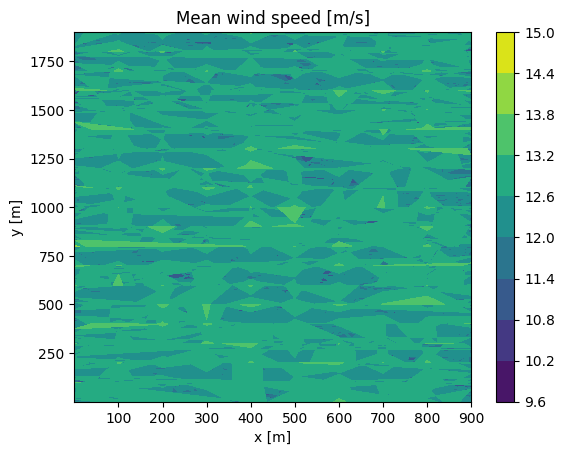

In [6]:
site_x, site_y = np.meshgrid(np.arange(0.1, 1000, 100), np.arange(0.1, 2000, 100))
site_x, site_y = site_x.flatten(), site_y.flatten()
site_time = np.arange(100)
site_ws = np.random.uniform(3.0, 21.0, (len(site_x), len(site_y), len(site_time)))
site_wd = np.random.uniform(0.0, 360.0, (len(site_x), len(site_y), len(site_time)))
ds = xr.Dataset(
    data_vars=dict(
        WS=(["x", "y", "time"], site_ws),
        WD=(["x", "y", "time"], site_wd),
        TI=(["x", "y", "time"], np.ones_like(site_ws) * 0.1),  # hardcoded TI=0.1
        P=1,  # deterministic wind resource
    ),
    coords=dict(
        x=("x", site_x),
        y=("y", site_y),
        time=("time", site_time),
    ),
)
non_uniform_ts_site = XRSite(ds)
wss_at_mean_loc = non_uniform_ts_site.local_wind(
    site_x.mean(), site_y.mean(), time=site_time
)["WS_ilk"]
print(f"Mean wind speed at the mean location: {wss_at_mean_loc.mean():.2f} m/s")

# check the map of the mean wind speed at the site
mean_resource = ds.WS.mean(dim="time").values
plt.contourf(site_x, site_y, mean_resource)
plt.colorbar()
plt.title("Mean wind speed [m/s]")
plt.xlabel("x [m]")
_ = plt.ylabel("y [m]")

## Wake effects from neighbouring wind farms

In [7]:
site3 = IEA37Site(16)

# setup current, neighbour and all positions
wt_x, wt_y = site3.initial_position.T
neighbour_x, neighbour_y = wt_x-4000, wt_y
all_x, all_y = np.r_[wt_x,neighbour_x], np.r_[wt_y,neighbour_y]

windTurbines = WindTurbines.from_WindTurbine_lst([IEA37_WindTurbines(),IEA37_WindTurbines()])
windTurbines._names = ["Current wind farm","Neighbour wind farm"]
types = [0]*len(wt_x) + [1]*len(neighbour_x)

wf_model = PropagateDownwind(site3, windTurbines,
                             wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                             superpositionModel=LinearSum())

# Consider wd=270 +/- 30 deg only
wd_lst = np.arange(240,301)

Text(0.5, 1.0, 'Wake map for 267 deg and 9.8 m/s')

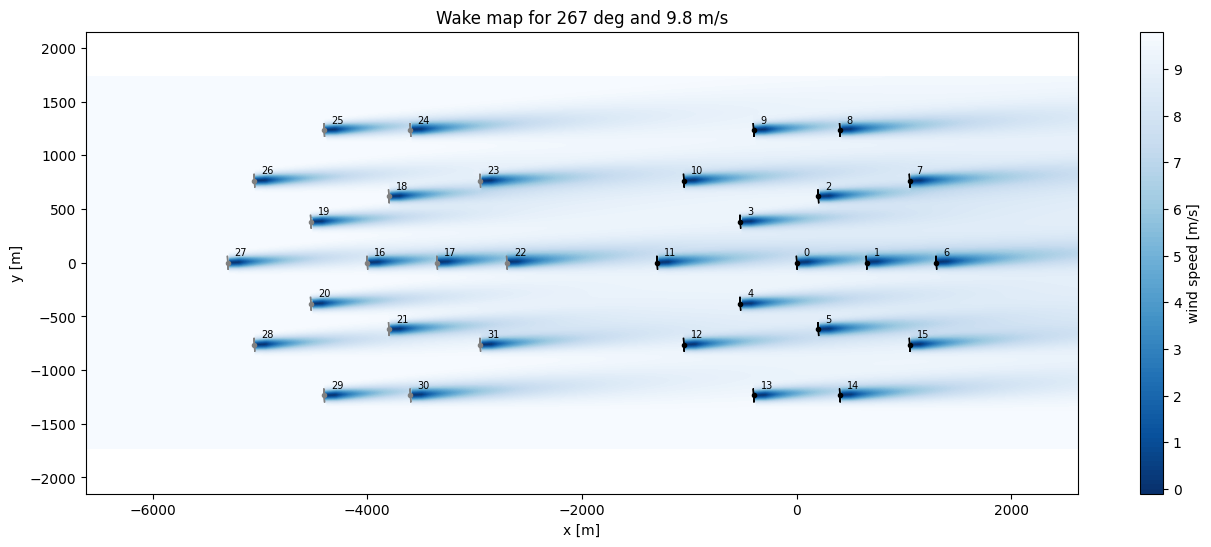

In [8]:
#plotting the wake maps for the desired flow case
wsp = 9.8
wdir = 267

plt.figure(figsize=(16, 6))
wf_model(all_x, all_y, type=types, wd=wdir, ws=wsp, h=110).flow_map().plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for'+ f' {wdir} deg and {wsp} m/s')

Now, we run the simulation of all wind turbines and calculate AEP of current wind farm

In [9]:
print("Total AEP: %f GWh"%wf_model(all_x, all_y, type=types, ws=[wsp], wd=wd_lst).aep().isel(wt=np.arange(len(wt_x))).sum())

Total AEP: 85.187662 GWh


We can also calculate the AEP of the current wind farm by enclosing it in a flow box and setting up a new wind farm model

In [10]:
#making a flow box covering the area of interest (i.e the current wind farm + 100m)

ext = 1000
flow_box = wf_model(neighbour_x, neighbour_y, wd=wd_lst).flow_box(
    x=np.linspace(min(wt_x) - ext, max(wt_x) + ext, 101),
    y=np.linspace(min(wt_y) - ext, max(wt_y) + ext, 101),
    h=110)

#creating new site based on the flow box

wake_site = XRSite.from_flow_box(flow_box)

Now, we plot the “free-stream” inflow wind speed of the current wind farm.

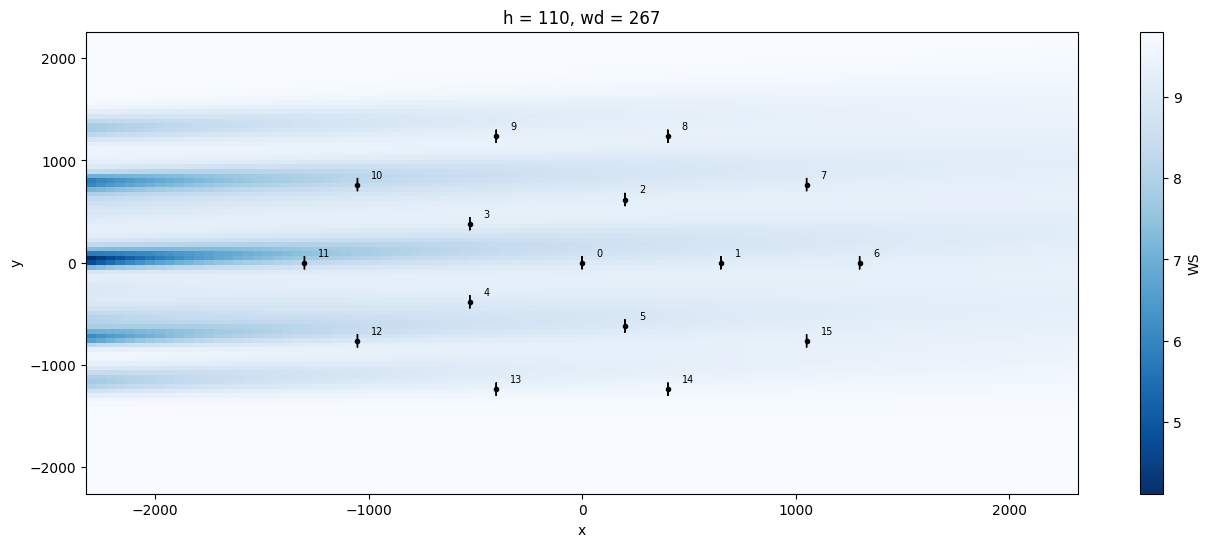

In [11]:
plt.figure(figsize=(16, 6))
wake_site.ds.WS.sel(wd=267).plot(y='y', cmap = 'Blues_r')
windTurbines.plot(all_x, all_y, types, wd=270)

Then, we setup a new wind farm model with the new pre-generated site and calculate the AEP.

In [12]:
wf_model_wake_site = PropagateDownwind(wake_site, windTurbines,
                                       wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                                       superpositionModel=LinearSum())

In [13]:
print("Total AEP: %f GWh"%wf_model_wake_site(wt_x, wt_y, ws=[wsp], wd=wd_lst).aep().sum())

Total AEP: 85.187032 GWh


Lastly, we plot the flow map of the current wind farm with the selected flow box.

Text(0, 0.5, 'y [m]')

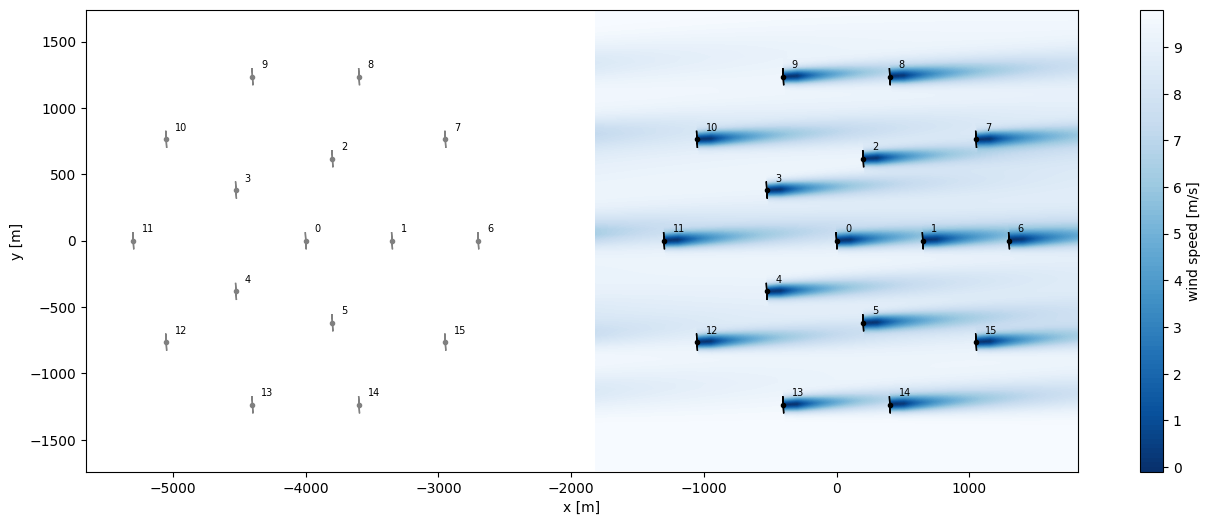

In [14]:
plt.figure(figsize=(16, 6))
wf_model_wake_site(wt_x, wt_y, wd=wdir, ws=wsp, h=110).flow_map().plot_wake_map()
windTurbines.plot(neighbour_x, neighbour_y, type=1, wd=wdir)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### Local wind